In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

## Load Data

In [112]:
df1 = pd.read_csv('loan_2015.csv')

In [113]:
df1.shape

(235631, 95)

In [114]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235631 entries, 0 to 235630
Data columns (total 95 columns):
bcopentobuy                   233184 non-null float64
initialliststatus             235629 non-null object
numactvbctl                   235629 non-null float64
grade                         235629 non-null object
mthssincelastrecord           41524 non-null float64
totcurbal                     235629 non-null float64
totalbalexmort                235629 non-null float64
subgrade                      235629 non-null object
mosinrcnttl                   235629 non-null float64
inqlast12m                    0 non-null float64
mortacc                       235629 non-null float64
mthssincelastdelinq           119748 non-null float64
verificationstatusjoint       0 non-null float64
numactvrevtl                  235629 non-null float64
tothicredlim                  235629 non-null float64
ficorangehigh                 235629 non-null float64
maxbalbc                      0 non-nul

## Select Data

In [115]:
all_null_feature =['inqlast12m',
 'verificationstatusjoint',
 'maxbalbc',
 'annualincjoint',
 'memberid',
 'openil6m',
 'openacc6m',
 'totalbalil',
 'inqfi',
 'mthssincercntil',
 'openrv24m',
 'openrv12m',
 'dtijoint',
 'openil12m',
 'openil24m',
 'allutil',
 'totalcutl',
 'ilutil']

In [116]:
ob_feature=['initialliststatus',
 'grade',
 'subgrade',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'desc',
 'term',
 'homeownership',
 'addrstate',
 'revolutil',
 'id',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose',
 'issued',
 'loanstatus']

In [117]:
num_feature=['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 'fundedamnt', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 'pubrecbankruptcies']

In [118]:
select_feature=ob_feature+num_feature
len(select_feature)

77

In [119]:
# remove applicationtype since it only has one value as 'individual'

ob_feature.remove('applicationtype')


In [120]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan

num_feature.remove('fundedamnt')


In [121]:
# remove 'id','issued' and 'loanstatus' from ob_feature, since they are index, train/test flag and target
ob_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')


In [122]:
# remove 'desc' from ob_feature and select_feature
ob_feature.remove('desc')


In [123]:
select_feature=ob_feature+num_feature
len(select_feature)

71

In [124]:
# selected features left and delete the last two rows
df=df1[select_feature+['id','loanstatus','issued']][:-2]

In [125]:
df.shape

(235629, 74)

## only use term=36 months and loanstatus = fully paid and charged off

In [126]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [127]:
df = df.query("term ==' 36 months'")

In [128]:
df.shape

(114925, 74)

In [129]:
df.drop('term', axis = 1, inplace=True)

In [130]:
df.shape

(114925, 73)

In [131]:
ob_feature.remove('term')

## Label Target

In [132]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [133]:
print df.loanstatus.value_counts()
print df.loanstatus.value_counts(normalize=True)

0    95346
1    19579
Name: loanstatus, dtype: int64
0    0.829637
1    0.170363
Name: loanstatus, dtype: float64


## Out of time testing set and in-time training set: Oct~Dec as test

In [134]:
issued=list(df['issued'].unique())
issued

['Dec-2014',
 'Nov-2014',
 'Oct-2014',
 'Sep-2014',
 'Aug-2014',
 'Jul-2014',
 'Jun-2014',
 'May-2014',
 'Apr-2014',
 'Mar-2014',
 'Feb-2014',
 'Jan-2014']

In [135]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df.train_flg.value_counts()

1    87032
0    27893
Name: train_flg, dtype: int64

In [136]:
df.drop('issued', axis = 1, inplace=True)

In [137]:
df.shape

(114925, 73)

## Feature Engineering & Cleaning

#### Datetime to numeric feature

In [138]:
df.earliestcrline.unique()[:5]

array(['Sep-1989', 'Aug-2002', 'Nov-1992', 'Oct-2001', 'Oct-1998'], dtype=object)

In [139]:
# convert to number of months to Dec 2014

In [140]:
cl_month=df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year=df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [141]:
cl_month.unique()

array(['Sep', 'Aug', 'Nov', 'Oct', 'Jan', 'May', 'Jul', 'Jun', 'Dec',
       'Mar', 'Feb', 'Apr'], dtype=object)

In [142]:
cl_year.unique()

array([1989, 2002, 1992, 2001, 1998, 1999, 2009, 2003, 1995, 1993, 1996,
       2004, 1988, 2007, 2011, 2010, 2006, 1997, 2008, 2000, 2005, 1986,
       1987, 1973, 1991, 1982, 1984, 1976, 1981, 1974, 1990, 1978, 1979,
       1994, 1983, 1971, 1985, 1967, 1972, 1968, 1980, 1977, 1965, 1975,
       1969, 1963, 1970, 1964, 1966, 1958, 1962, 1959, 1955, 1960, 1961,
       1954, 1957, 1950, 1948, 1953, 1956], dtype=int64)

In [143]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [144]:
df['earliestcrline_month']=df.earliestcrline.apply(lambda x: (2014-int(x.split('-')[1]))*12+dic_month[x.split('-')[0]])

In [145]:
df.earliestcrline_month[:5]

0    303
3    148
4    265
6    158
9    194
Name: earliestcrline_month, dtype: int64

In [146]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')


In [147]:
print len(ob_feature), len(num_feature)

12 58


In [148]:
df.drop('earliestcrline', axis = 1, inplace=True)

In [149]:
df.shape

(114925, 73)

### emplength to numeric feature

In [150]:
print df['emplength'].isnull().sum()
df['emplength'].unique()

0


array(['8 years', '< 1 year', '10+ years', '2 years', '9 years', '7 years',
       '1 year', 'n/a', '3 years', '5 years', '4 years', '6 years'], dtype=object)

In [151]:
df['emplength'].replace('n/a', np.nan, inplace=True)
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [152]:
df.emplength.value_counts()

 10     35800
 2      10551
 0       9407
 3       9383
 1       7559
 4       6734
 5       6559
-999     6427
 7       6401
 6       5966
 8       5712
 9       4426
Name: emplength, dtype: int64

In [153]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print len(num_feature), len(ob_feature)

59 11


In [154]:
df.shape

(114925, 73)

## % to numeric feature: intrate, revolutil

In [155]:
intrate=df.intrate.apply(lambda x: float(x.replace('%','')))

In [156]:
df.intrate=intrate
df.intrate[:2]

0     6.99
3    13.66
Name: intrate, dtype: float64

In [157]:
df.revolutil = pd.Series(df.revolutil).str.replace('%', '').astype(float)

In [158]:
df.revolutil[:2]

0    31.6
3    91.9
Name: revolutil, dtype: float64

In [159]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [160]:
print len(ob_feature), len(num_feature)

9 61


#### Ordinal feature encoding : grade, subgrade

In [161]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [162]:
df.grade = df.grade.map(Dic_grade)

In [163]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [164]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [165]:
print len(ob_feature), len(num_feature)

7 63


### High cardinality feature encoding

###### Zip Code - frequency encoding 

In [166]:
print df.zipcode.nunique(), df.zipcode.unique()[:5]

847 ['937xx' '850xx' '077xx' '554xx' '982xx']


In [167]:
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3])

In [168]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [169]:
zipcode_freq[:5]

,zipcode,0
0,008,1
1,010,157
2,011,43
3,012,41
4,013,29


In [170]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [171]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [173]:
ob_feature.remove('zipcode')
num_feature.append('zipcode_freq')
num_feature.append('zipcode')
print len(ob_feature), len(num_feature)

6 64


### emptitle-frequency encoding (can do some NLP for later stage)

In [174]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")


In [175]:
df.drop("emptitle", axis = 1, inplace=True)

In [176]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print len(ob_feature), len(num_feature)

5 65


###### Addr_state - frequency encoding

In [177]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")


In [178]:
df.drop("addrstate", axis = 1, inplace=True)

In [179]:
ob_feature.remove('addrstate')
num_feature.append('addrestate_freq')
print len(ob_feature), len(num_feature)

4 66


#### One hot encoding

In [180]:
dummy_feature = ["homeownership", "verificationstatus", "purpose", "initialliststatus"]

In [181]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [182]:
df_dummy.shape

(114925, 22)

In [183]:
df=pd.concat([df,df_dummy], axis=1 )

In [184]:
df.shape

(114925, 95)

In [185]:
df.drop(dummy_feature, axis = 1, inplace=True)

In [186]:
df.shape

(114925, 91)

##  XGBoost 

In [187]:
feat=list(df.columns.values)
print feat

['grade', 'subgrade', 'intrate', 'revolutil', 'emplength', 'bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 'pubrecbankruptci

In [188]:
feat.remove('id')
feat.remove('loanstatus')
feat.remove('train_flg')

### Preliminary manually parameter tuning based on stratified train-test split

In [17]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
X = np.array([[0, 2], [1, 4], [2, 2], [3, 4], [4, 8], [5, 6], [6,4], [7,3]])
y = np.array([0, 0, 1, 1,1,0,1,1])
skf = StratifiedKFold(n_splits=3, shuffle = True)
skf.get_n_splits(X, y)


3

In [13]:
X

array([[0, 2],
       [1, 4],
       [2, 2],
       [3, 4],
       [4, 8],
       [5, 6],
       [6, 4],
       [7, 3]])

In [18]:
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)

TRAIN: [0 1 2 3 7] TEST: [4 5 6]
[[0 2]
 [1 4]
 [2 2]
 [3 4]
 [7 3]] [[4 8]
 [5 6]
 [6 4]] [0 0 1 1 1] [1 0 1]
TRAIN: [0 2 4 5 6] TEST: [1 3 7]
[[0 2]
 [2 2]
 [4 8]
 [5 6]
 [6 4]] [[1 4]
 [3 4]
 [7 3]] [0 1 1 0 1] [0 1 1]
TRAIN: [1 3 4 5 6 7] TEST: [0 2]
[[1 4]
 [3 4]
 [4 8]
 [5 6]
 [6 4]
 [7 3]] [[0 2]
 [2 2]] [0 1 1 0 1 1] [0 1]


In [189]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
#Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

In [190]:
df_train = df.query("train_flg == 1")
df_test =df.query("train_flg == 0" )

In [191]:
print df_train.shape, df_test.shape

(87032, 91) (27893, 91)


In [192]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2016, stratify = df_train.loanstatus )

In [193]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [194]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [195]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1441, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} # 74453

In [196]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,\
  early_stopping_rounds= 50)

[0]	train-auc:0.67486	eval-auc:0.658041
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.687507	eval-auc:0.667688
[2]	train-auc:0.699385	eval-auc:0.672948
[3]	train-auc:0.705821	eval-auc:0.677469
[4]	train-auc:0.707811	eval-auc:0.679267
[5]	train-auc:0.712244	eval-auc:0.682179
[6]	train-auc:0.713443	eval-auc:0.682608
[7]	train-auc:0.714757	eval-auc:0.682514
[8]	train-auc:0.715926	eval-auc:0.682501
[9]	train-auc:0.716767	eval-auc:0.682351
[10]	train-auc:0.717084	eval-auc:0.683027
[11]	train-auc:0.718006	eval-auc:0.68371
[12]	train-auc:0.718542	eval-auc:0.684115
[13]	train-auc:0.719352	eval-auc:0.684586
[14]	train-auc:0.720061	eval-auc:0.684839
[15]	train-auc:0.720278	eval-auc:0.685406
[16]	train-auc:0.720991	eval-auc:0.685527
[17]	train-auc:0.721754	eval-auc:0.685651
[18]	train-auc:0.72348	eval-auc:0.686328
[19]	train-auc:0.723989	eval-auc:0.686517
[20]	train-auc:0.724551	eval-auc

In [197]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print "Area under the ROC curve - validation: %f" % roc_auc
    print "Area under the ROC curve - train: %f" % roc_auc_1
    print "Area under the ROC curve - test: %f" % roc_auc_2
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - test(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()


### ROC curve

Area under the ROC curve - validation: 0.699226
Area under the ROC curve - train: 0.802750
Area under the ROC curve - test: 0.710706


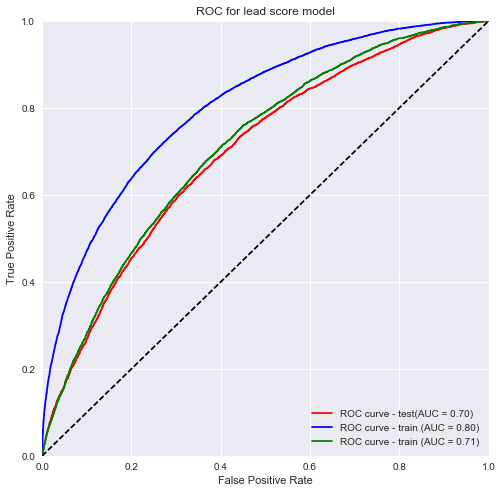

In [198]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

### Distribution of predicted values

In [199]:
y_pred = gbm.predict(dtest)

In [200]:
print y_pred.max(), y_pred.min(), y_pred.mean()

0.763708 0.00947124 0.172812


### Feature importance

In [201]:
importance=gbm.get_fscore()

In [202]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [203]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
52,dti,0.043001
4,mosinoldilacct,0.039478
5,annualinc,0.039063
67,installment,0.034297
45,mosinoldrevtlop,0.033261
55,emptitle_freq,0.029945
0,bcopentobuy,0.029634
74,avgcurbal,0.028287
46,zipcode_freq,0.027666
62,bcutil,0.027044


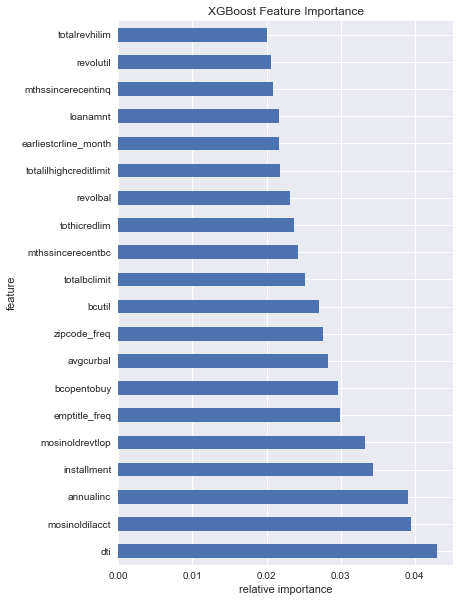

In [204]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [205]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
7,grade,0.005284


In [206]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
13,subgrade,0.019998


In [207]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
57,intrate,0.018547


In [208]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
64,loanamnt,0.021656


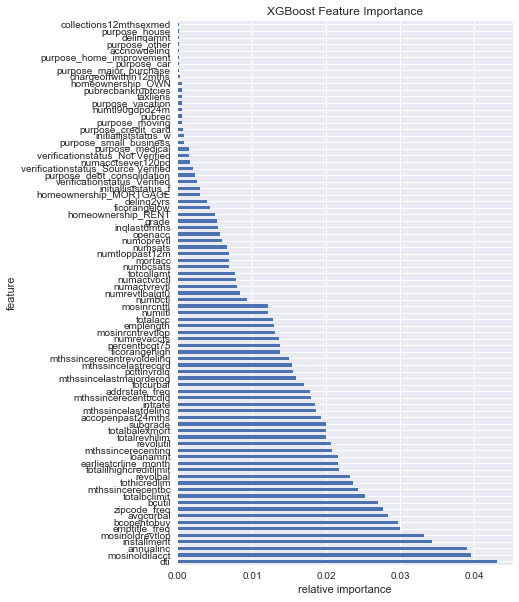

In [209]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

## Hyperparameter Tuning - Bayesian Optimization

In [105]:
from bayes_opt import BayesianOptimization

train_x = df_train[feat]
train_y = df_train.loanstatus

xgtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)  

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = False 



    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round=100000,
                       nfold=3,
                       metrics={'auc'},
                       seed=1234,
                       callbacks=[xgb.callback.early_stop(50)])
    print(cv_result)

    return cv_result['test-auc-mean'].max()


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (4, 8),
                              'min_child_weight': (0, 20),
                              'colsample_bytree': (0.2, 0.8),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2)
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=40)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[310]	train-auc:0.815517+0.00223829	test-auc:0.700247+0.00384879

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.657448      0.006211        0.669501       0.002697
1         0.665993      0.005821        0.682125       0.001627
2         0.669829      0.004683        0.689166       0.002900
3         0.672513      0.005513        0.695121       0.004847
4         0.675233      0.005778        0.698789       0.003748
5         0.676858      0.005361        0.702392       0.005311
6         0.678073      0.005944        0.705115       0.005101
7         0.678

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00016717]), 'nit': 7, 'funcalls': 51}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.46691928e-05]), 'nit': 8, 'funcalls': 52}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


    6 | 02m07s |    0.70090 |             0.3169 |    0.1446 |      4.6053 |            19.7811 |      0.6072 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[517]	train-auc:0.766275+0.0014962	test-auc:0.70004+0.00396082

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.654997      0.006430        0.660419       0.001066
1         0.662460      0.006682        0.668587       0.001295
2         0.665909      0.005073        0.672428       0.002769
3         0.668418      0.005739        0.676011       0.004101
4         0.671209      0.003073        0.679463       0.006202
5         0.671936      0.002402        0.681053       0.006692
6         0.673968      0.003965        0.683670       0.005432
7         0.673978      0.005530        0.683463       0.004567
8         0.675092      0.005745        0.684666       0.004950
9         0.6753

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.46843639e-05]), 'nit': 4, 'funcalls': 51}
  " state: %s" % convergence_dict)


   10 | 02m09s |    0.70140 |             0.2699 |    1.8176 |      4.1906 |            18.7939 |      0.9485 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[350]	train-auc:0.799419+0.000412689	test-auc:0.7001+0.00473614

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.657535      0.004413        0.665514       0.001997
1         0.666530      0.004106        0.678047       0.003509
2         0.669520      0.003706        0.681892       0.003503
3         0.673238      0.003812        0.687286       0.003922
4         0.675225      0.005253        0.690529       0.003316
5         0.675780      0.005963        0.691781       0.003309
6         0.677305      0.006082        0.694657       0.003331
7         0.678330      0.006577        0.695406       0.004183
8         0.678767      0.006917        0.695688       0.004035
9         0.679

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00017375]), 'nit': 6, 'funcalls': 54}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.31485628e-05]), 'nit': 4, 'funcalls': 51}
  " state: %s" % convergence_dict)


   18 | 02m07s |    0.70140 |             0.4181 |    0.2915 |      4.3791 |             7.7920 |      0.9132 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[440]	train-auc:0.77996+0.0015803	test-auc:0.70081+0.00327288

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.656750      0.004034        0.663006       0.002207
1         0.665988      0.003506        0.673822       0.003894
2         0.668562      0.003787        0.677275       0.003060
3         0.669954      0.004269        0.678611       0.002702
4         0.671205      0.004560        0.680492       0.002372
5         0.672355      0.005925        0.682158       0.002377
6         0.673235      0.006208        0.683087       0.002080
7         0.674929      0.005859        0.684525       0.002060
8         0.675218      0.006039        0.684896       0.001788
9         0.67555

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00010323]), 'nit': 6, 'funcalls': 63}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00127603]), 'nit': 3, 'funcalls': 50}
  " state: %s" % convergence_dict)


   21 | 01m50s |    0.70154 |             0.2619 |    0.5749 |      4.4303 |            18.2289 |      0.7466 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[446]	train-auc:0.778009+0.00156912	test-auc:0.701405+0.00413091

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.658565      0.003616        0.663240       0.002057
1         0.667346      0.004363        0.673602       0.004204
2         0.669194      0.004791        0.676396       0.003919
3         0.671016      0.004043        0.679818       0.006137
4         0.672182      0.004574        0.680965       0.005428
5         0.673331      0.005591        0.682229       0.004832
6         0.674834      0.005418        0.684820       0.005608
7         0.675402      0.005484        0.685565       0.005881
8         0.675473      0.005286        0.685872       0.004970
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00012024]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00129389]), 'nit': 6, 'funcalls': 82}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.06100238e-05]), 'nit': 6, 'funcalls': 57}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b

   22 | 02m06s |    0.70140 |             0.4181 |    0.2915 |      4.3791 |             7.7920 |      0.9132 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[438]	train-auc:0.766409+0.00178038	test-auc:0.701538+0.00428501

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.656308      0.004210        0.661925       0.002366
1         0.663707      0.005668        0.670479       0.001437
2         0.666532      0.004531        0.673308       0.002777
3         0.670446      0.004166        0.678004       0.003208
4         0.672029      0.004019        0.680161       0.003030
5         0.674218      0.004139        0.683046       0.004375
6         0.675454      0.005148        0.685150       0.004011
7         0.675704      0.006267        0.685008       0.004280
8         0.675807      0.006237        0.685192       0.004632
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.40509861e-05]), 'nit': 6, 'funcalls': 52}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.77740840e-05]), 'nit': 9, 'funcalls': 90}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.99627027e-05]), 'nit': 8, 'funcalls': 68}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmi

   23 | 01m59s |    0.70154 |             0.2619 |    0.5749 |      4.4303 |            18.2289 |      0.7466 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[438]	train-auc:0.76643+0.00178444	test-auc:0.701537+0.00428359

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.656308      0.004210        0.661925       0.002366
1         0.663707      0.005668        0.670479       0.001437
2         0.666532      0.004531        0.673308       0.002777
3         0.670446      0.004166        0.678004       0.003208
4         0.672029      0.004019        0.680161       0.003030
5         0.674218      0.004139        0.683046       0.004375
6         0.675454      0.005148        0.685150       0.004011
7         0.675704      0.006267        0.685008       0.004280
8         0.675807      0.006237        0.685192       0.004632
9         0.675

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00417829]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00422625]), 'nit': 7, 'funcalls': 67}
  " state: %s" % convergence_dict)


   24 | 01m55s |    0.70154 |             0.2619 |    0.5749 |      4.4303 |            18.2289 |      0.7466 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[357]	train-auc:0.756505+0.00179698	test-auc:0.701347+0.00443

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.656308      0.004210        0.661925       0.002366
1         0.663707      0.005668        0.670479       0.001437
2         0.666532      0.004531        0.673308       0.002777
3         0.670442      0.004164        0.678004       0.003208
4         0.672030      0.004018        0.680163       0.003031
5         0.674231      0.004124        0.683064       0.004395
6         0.675464      0.005137        0.685163       0.004026
7         0.675716      0.006252        0.685024       0.004295
8         0.675818      0.006222        0.685209       0.004652
9         0.67541

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -7.18995242e-05]), 'nit': 5, 'funcalls': 47}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00174634]), 'nit': 4, 'funcalls': 54}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00926099]), 'nit': 2, 'funcalls': 49}
  " state: %s" % convergence_dict)


   25 | 01m26s |    0.70135 |             0.2619 |    0.5749 |      4.4303 |            18.2289 |      0.7466 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[235]	train-auc:0.838632+0.00352438	test-auc:0.698831+0.00365763

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.656572      0.002959        0.676310       0.002001
1         0.668766      0.003027        0.693059       0.003193
2         0.671669      0.003331        0.697821       0.003299
3         0.673957      0.003529        0.703264       0.006674
4         0.675164      0.004227        0.705813       0.006134
5         0.676083      0.005041        0.708716       0.006104
6         0.677902      0.005139        0.711978       0.007261
7         0.678358      0.005024        0.713092       0.007750
8         0.679067      0.004956        0.714280       0.006243
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.48948266e-05]), 'nit': 10, 'funcalls': 81}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00011716]), 'nit': 7, 'funcalls': 54}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00040864]), 'nit': 7, 'funcalls': 63}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_

   26 | 01m22s |    0.69883 |             0.3971 |    0.8646 |      6.0936 |             1.7775 |      0.9288 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[359]	train-auc:0.880195+0.0018676	test-auc:0.699176+0.00346486

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.658677      0.003603        0.676094       0.000772
1         0.669193      0.003056        0.692857       0.002358
2         0.672188      0.003821        0.697936       0.002283
3         0.674216      0.003958        0.703574       0.005747
4         0.675778      0.003805        0.706670       0.005349
5         0.676498      0.004656        0.709560       0.004647
6         0.676703      0.005399        0.710994       0.005014
7         0.678378      0.005407        0.713649       0.004931
8         0.678847      0.005383        0.714338       0.004089
9         0.679

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.07077703e-05]), 'nit': 8, 'funcalls': 69}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.32036915e-05]), 'nit': 8, 'funcalls': 85}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00072996]), 'nit': 3, 'funcalls': 64}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_b

   27 | 02m01s |    0.69918 |             0.4442 |    0.8432 |      6.1522 |             1.6814 |      0.9083 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[461]	train-auc:0.770673+0.00153239	test-auc:0.700252+0.00352681

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.655587      0.004950        0.660330       0.000953
1         0.664122      0.006735        0.670560       0.001299
2         0.667098      0.005341        0.674186       0.002615
3         0.670304      0.005732        0.678430       0.003398
4         0.671805      0.005259        0.680623       0.003498
5         0.673822      0.005185        0.683278       0.004049
6         0.675322      0.006240        0.685252       0.003822
7         0.675429      0.007095        0.685100       0.003851
8         0.675551      0.006825        0.685606       0.004368
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  6.69479961e-05]), 'nit': 4, 'funcalls': 52}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00805537]), 'nit': 7, 'funcalls': 111}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00075948]), 'nit': 7, 'funcalls': 71}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_

   28 | 01m49s |    0.70025 |             0.2726 |    0.1911 |      4.5015 |            11.1893 |      0.5885 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[357]	train-auc:0.757403+0.00140382	test-auc:0.699539+0.00432138

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.655703      0.005350        0.660715       0.000816
1         0.663080      0.006142        0.669884       0.001248
2         0.666392      0.004918        0.673564       0.002713
3         0.669169      0.005247        0.677558       0.003958
4         0.670582      0.004909        0.679777       0.003768
5         0.672754      0.005039        0.682589       0.004367
6         0.674446      0.006124        0.684835       0.004041
7         0.674824      0.006952        0.684704       0.004246
8         0.674940      0.006697        0.685099       0.004742
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.33567873e-05]), 'nit': 7, 'funcalls': 65}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0017643]), 'nit': 5, 'funcalls': 53}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.00486708e-05]), 'nit': 8, 'funcalls': 57}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bf

   29 | 01m31s |    0.69954 |             0.2568 |    0.1637 |      4.5438 |            11.2227 |      0.6111 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[465]	train-auc:0.771965+0.00166511	test-auc:0.700784+0.00406144

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.656085      0.004490        0.661901       0.002621
1         0.665145      0.004539        0.671825       0.003010
2         0.667589      0.004653        0.675059       0.002998
3         0.670387      0.004823        0.679176       0.003977
4         0.672630      0.005528        0.681876       0.003422
5         0.673645      0.005083        0.683442       0.004134
6         0.674167      0.005139        0.685026       0.003946
7         0.674663      0.006317        0.685081       0.003935
8         0.675007      0.006241        0.685645       0.004506
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00032507]), 'nit': 8, 'funcalls': 78}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01146074]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00012626]), 'nit': 6, 'funcalls': 60}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b term

   30 | 01m52s |    0.70078 |             0.2849 |    0.2248 |      4.5485 |            11.2275 |      0.5908 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[478]	train-auc:0.772273+0.00176188	test-auc:0.700379+0.00386013

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.657473      0.004667        0.662177       0.002567
1         0.665247      0.005325        0.671420       0.002642
2         0.668224      0.005169        0.675103       0.002433
3         0.672138      0.005238        0.679182       0.003475
4         0.673751      0.005017        0.681699       0.003072
5         0.674079      0.004128        0.682944       0.003973
6         0.675284      0.004688        0.684490       0.003859
7         0.675546      0.006010        0.684583       0.003535
8         0.675696      0.006239        0.685108       0.003987
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.29700904e-05]), 'nit': 9, 'funcalls': 77}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01703072]), 'nit': 3, 'funcalls': 48}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00045164]), 'nit': 4, 'funcalls': 68}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b

   31 | 01m54s |    0.70038 |             0.2935 |    0.1665 |      4.5429 |            11.2210 |      0.5463 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[460]	train-auc:0.771747+0.00224708	test-auc:0.700268+0.00407433

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.655357      0.004884        0.660723       0.001406
1         0.665319      0.003902        0.671991       0.003422
2         0.667868      0.003808        0.675142       0.003284
3         0.671569      0.003250        0.679583       0.004769
4         0.673601      0.004545        0.681999       0.004137
5         0.674349      0.004225        0.683556       0.004881
6         0.675567      0.005284        0.685331       0.004713
7         0.675999      0.006228        0.685540       0.004704
8         0.676071      0.006049        0.685984       0.005248
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00039986]), 'nit': 4, 'funcalls': 59}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00253184]), 'nit': 7, 'funcalls': 60}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.45070058e-05]), 'nit': 9, 'funcalls': 63}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b

   32 | 01m50s |    0.70027 |             0.2860 |    0.1829 |      4.4948 |            11.2658 |      0.5850 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[472]	train-auc:0.768375+0.00192397	test-auc:0.7002+0.00392045

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.656472      0.003200        0.660987       0.003273
1         0.663807      0.005719        0.669565       0.001241
2         0.666925      0.005247        0.672777       0.002324
3         0.669581      0.005395        0.676450       0.003355
4         0.671830      0.003185        0.679772       0.005251
5         0.672967      0.002257        0.681611       0.006153
6         0.675241      0.004750        0.684260       0.004661
7         0.675035      0.005742        0.683937       0.004030
8         0.675729      0.006077        0.685140       0.004600
9         0.6757

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00393009]), 'nit': 9, 'funcalls': 76}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00054349]), 'nit': 7, 'funcalls': 88}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00054957]), 'nit': 8, 'funcalls': 83}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b term

   33 | 01m47s |    0.70020 |             0.2162 |    0.2024 |      4.5211 |            11.2455 |      0.5432 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[272]	train-auc:0.854189+0.00351331	test-auc:0.698855+0.00382304

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.658348      0.003058        0.676157       0.001146
1         0.669131      0.002539        0.692021       0.002860
2         0.671931      0.003277        0.697225       0.002918
3         0.674555      0.002771        0.702766       0.006098
4         0.675802      0.003257        0.705920       0.005706
5         0.676384      0.004437        0.708873       0.005067
6         0.677243      0.003973        0.710929       0.006223
7         0.678026      0.004347        0.712493       0.006673
8         0.678716      0.004334        0.713735       0.005373
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00191858]), 'nit': 5, 'funcalls': 67}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  8.31987835e-05]), 'nit': 8, 'funcalls': 58}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00175967]), 'nit': 8, 'funcalls': 79}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b

   34 | 01m36s |    0.69885 |             0.4250 |    0.9042 |      6.1868 |             1.7567 |      0.9142 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[289]	train-auc:0.857629+0.00367523	test-auc:0.698375+0.00449145

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.659540      0.004393        0.676521       0.002043
1         0.668483      0.003563        0.692971       0.003200
2         0.671163      0.003966        0.697472       0.002905
3         0.673224      0.004260        0.703640       0.006534
4         0.674849      0.004515        0.706942       0.005979
5         0.675810      0.005679        0.709754       0.005098
6         0.676005      0.006249        0.710665       0.005021
7         0.677903      0.006232        0.713076       0.005053
8         0.678545      0.006368        0.714223       0.004344
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.13391018]), 'nit': 7, 'funcalls': 103}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.08470058]), 'nit': 5, 'funcalls': 76}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -5.65126988e-05]), 'nit': 7, 'funcalls': 63}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_

   35 | 01m57s |    0.69837 |             0.4615 |    0.8487 |      6.1644 |             1.7604 |      0.9779 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[243]	train-auc:0.779755+0.000722196	test-auc:0.699006+0.00330797

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.655109      0.002586        0.667430       0.001600
1         0.667478      0.003164        0.681160       0.003443
2         0.671174      0.003278        0.686699       0.003383
3         0.673426      0.003413        0.689174       0.002749
4         0.675067      0.004562        0.691320       0.002697
5         0.676098      0.004568        0.692882       0.002151
6         0.677534      0.004635        0.695001       0.001953
7         0.678256      0.004433        0.695997       0.001816
8         0.678673      0.004712        0.696786       0.001810
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00010147]), 'nit': 8, 'funcalls': 56}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00145181]), 'nit': 6, 'funcalls': 55}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  5.14645845e-05]), 'nit': 8, 'funcalls': 57}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b

   36 | 01m47s |    0.69901 |             0.6981 |    1.8344 |      5.1557 |             9.8183 |      0.5445 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[213]	train-auc:0.797932+0.0010138	test-auc:0.699344+0.00340871

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.659882      0.003745        0.674283       0.001291
1         0.670897      0.002775        0.690639       0.003572
2         0.674241      0.002603        0.696100       0.003885
3         0.675712      0.003309        0.699418       0.003796
4         0.677602      0.004111        0.702659       0.003165
5         0.678466      0.004371        0.704422       0.002817
6         0.680426      0.004706        0.706997       0.002426
7         0.681110      0.004589        0.708334       0.002345
8         0.681656      0.004998        0.709266       0.002213
9         0.682

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.14402199]), 'nit': 4, 'funcalls': 69}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  4.95910645e-05]), 'nit': 7, 'funcalls': 73}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.04269409]), 'nit': 5, 'funcalls': 53}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b

   37 | 01m49s |    0.69934 |             0.7069 |    1.8209 |      6.7244 |            19.3900 |      0.6351 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[160]	train-auc:0.831536+0.00124886	test-auc:0.69678+0.00342607

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.650222      0.001429        0.676334       0.001771
1         0.665074      0.001575        0.699829       0.003167
2         0.670242      0.001044        0.708509       0.002263
3         0.672246      0.002541        0.713238       0.002315
4         0.674615      0.003432        0.718103       0.003237
5         0.675914      0.004494        0.721058       0.003497
6         0.678148      0.004952        0.724354       0.004069
7         0.679957      0.004311        0.726591       0.003646
8         0.680495      0.004758        0.728538       0.003044
9         0.681

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00240303]), 'nit': 4, 'funcalls': 55}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01968173]), 'nit': 4, 'funcalls': 59}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00038034]), 'nit': 8, 'funcalls': 110}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b ter

   38 | 01m32s |    0.69678 |             0.5751 |    0.4988 |      7.7815 |             6.3231 |      0.5814 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[282]	train-auc:0.855076+0.0030574	test-auc:0.697871+0.00399245

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.655970      0.003548        0.667694       0.001472
1         0.665532      0.002802        0.683586       0.002374
2         0.669092      0.003621        0.690825       0.002077
3         0.671946      0.005548        0.698204       0.003286
4         0.674179      0.006918        0.702200       0.003216
5         0.674858      0.007011        0.704562       0.003670
6         0.675758      0.006913        0.707911       0.004824
7         0.676853      0.007544        0.709101       0.005358
8         0.677661      0.007669        0.710348       0.004204
9         0.678

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00488091]), 'nit': 4, 'funcalls': 63}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00208855]), 'nit': 8, 'funcalls': 78}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.01519203]), 'nit': 7, 'funcalls': 91}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b term

   39 | 01m42s |    0.69787 |             0.3509 |    0.1367 |      6.1927 |             0.7177 |      0.6401 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[181]	train-auc:0.828266+0.00163341	test-auc:0.698575+0.00402916

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.658616      0.004366        0.674650       0.000914
1         0.670062      0.002722        0.690903       0.003548
2         0.673435      0.002853        0.697331       0.004761
3         0.675217      0.003648        0.701159       0.004754
4         0.676533      0.004129        0.705271       0.003741
5         0.677122      0.004773        0.707156       0.003051
6         0.678562      0.005041        0.709900       0.002501
7         0.679026      0.004819        0.711959       0.002347
8         0.679468      0.005001        0.713456       0.002330
9         0.68

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00018427]), 'nit': 7, 'funcalls': 79}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01242929]), 'nit': 8, 'funcalls': 63}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00158156]), 'nit': 6, 'funcalls': 73}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b term

   40 | 01m43s |    0.69857 |             0.7138 |    1.8192 |      6.7110 |             0.9153 |      0.6647 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[323]	train-auc:0.768208+0.00177564	test-auc:0.70007+0.00387351

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.653505      0.005414        0.661157       0.001405
1         0.665925      0.005326        0.673809       0.003826
2         0.669751      0.004336        0.678136       0.003765
3         0.671317      0.004819        0.679605       0.003387
4         0.672900      0.005448        0.681864       0.003417
5         0.673786      0.005198        0.682863       0.003458
6         0.674957      0.005295        0.684578       0.003124
7         0.675621      0.005283        0.685429       0.002872
8         0.675898      0.005324        0.685880       0.002721
9         0.676

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01444149]), 'nit': 6, 'funcalls': 58}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00025654]), 'nit': 8, 'funcalls': 68}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01897812]), 'nit': 8, 'funcalls': 78}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b term

   41 | 02m04s |    0.70007 |             0.6501 |    1.3446 |      4.0400 |             2.0590 |      0.5451 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[306]	train-auc:0.836973+0.00196472	test-auc:0.699635+0.00416605

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.659352      0.005896        0.679655       0.001500
1         0.669362      0.002962        0.693833       0.003604
2         0.673129      0.002562        0.699274       0.004252
3         0.674560      0.002283        0.702211       0.004093
4         0.676457      0.003256        0.705496       0.002960
5         0.677802      0.003815        0.707362       0.002560
6         0.678789      0.004428        0.709256       0.002322
7         0.679529      0.004456        0.710636       0.002413
8         0.679914      0.004506        0.711862       0.002743
9         0.68

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00155173]), 'nit': 7, 'funcalls': 78}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -5.65947387e-05]), 'nit': 7, 'funcalls': 76}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00016115]), 'nit': 8, 'funcalls': 83}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b

   42 | 02m21s |    0.69964 |             0.7071 |    1.9707 |      6.3227 |            12.4010 |      0.8548 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[478]	train-auc:0.781703+0.00117392	test-auc:0.700675+0.00332727

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.655496      0.003300        0.662817       0.002490
1         0.665748      0.002701        0.673752       0.004160
2         0.668193      0.003330        0.676543       0.003597
3         0.669693      0.003995        0.678071       0.002700
4         0.670718      0.004440        0.679934       0.002368
5         0.671902      0.005263        0.681666       0.002331
6         0.673204      0.006041        0.682720       0.001969
7         0.674856      0.005585        0.684198       0.001950
8         0.675066      0.005779        0.684577       0.001619
9         0.67

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0097065]), 'nit': 5, 'funcalls': 59}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00665474]), 'nit': 6, 'funcalls': 80}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00215745]), 'nit': 6, 'funcalls': 51}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b termi

   43 | 02m24s |    0.70067 |             0.4777 |    0.9680 |      4.3263 |            10.4061 |      0.7422 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[177]	train-auc:0.808251+0.0025527	test-auc:0.697541+0.00389796

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.652898      0.002129        0.671205       0.000767
1         0.666696      0.001840        0.689705       0.003682
2         0.671039      0.002574        0.696907       0.003254
3         0.672971      0.003535        0.700659       0.002600
4         0.674677      0.004689        0.704337       0.003012
5         0.675909      0.005481        0.706400       0.003356
6         0.677439      0.005615        0.708707       0.003309
7         0.678384      0.005280        0.710426       0.002630
8         0.678976      0.005065        0.711866       0.002344
9         0.679

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00977745]), 'nit': 6, 'funcalls': 90}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00019323]), 'nit': 9, 'funcalls': 91}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00025478]), 'nit': 7, 'funcalls': 100}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b ter

   44 | 01m31s |    0.69754 |             0.5782 |    0.0147 |      6.0689 |             3.3636 |      0.5739 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[377]	train-auc:0.762907+0.000774321	test-auc:0.700652+0.00472876

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.654658      0.004716        0.662012       0.001814
1         0.665458      0.004664        0.672721       0.002945
2         0.668740      0.004659        0.675853       0.003050
3         0.671757      0.004794        0.680161       0.004533
4         0.672380      0.005570        0.681485       0.004213
5         0.672988      0.006131        0.682462       0.003732
6         0.674751      0.005562        0.684770       0.004202
7         0.675039      0.005421        0.685119       0.004653
8         0.675614      0.005425        0.685476       0.003580
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00191593]), 'nit': 8, 'funcalls': 80}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0264082]), 'nit': 5, 'funcalls': 60}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.14712524e-05]), 'nit': 6, 'funcalls': 56}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b 

   45 | 01m55s |    0.70065 |             0.3690 |    1.8147 |      4.7766 |            13.3952 |      0.6875 | 


In [106]:
## Tuning results
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head(3)

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
10,0.261858,0.57485,4.430253,18.228898,0.74657,0.701539
17,0.261858,0.57485,4.430253,18.228897,0.74657,0.701538
15,0.261858,0.57485,4.430253,18.228897,0.74657,0.701538


In [210]:
%%time
# parameter set 1
params = {'objective': 'binary:logistic'
                  , 'booster': 'gbtree'
                  , 'eta': 0.01
                  , 'max_depth': 4     
                  , 'min_child_weight': 18   
                  , 'subsample': 0.74657   
                  , 'colsample_bytree': 0.261858  
                  , 'gamma': 0.57485               
                  , 'seed': 1234
                  , 'nthread': -1
                  , 'silence': 1
                  , 'eval_metric': 'auc'
                  , 'scale_pos_weight': 1}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round=10000
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

# [3393]	train-auc:0.772549	eval-auc:0.728445

[0]	train-auc:0.66389	eval-auc:0.660693
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.670481	eval-auc:0.667875
[2]	train-auc:0.676746	eval-auc:0.67189
[3]	train-auc:0.678097	eval-auc:0.673822
[4]	train-auc:0.680261	eval-auc:0.675601
[5]	train-auc:0.684102	eval-auc:0.678059
[6]	train-auc:0.68493	eval-auc:0.678341
[7]	train-auc:0.685698	eval-auc:0.6794
[8]	train-auc:0.68535	eval-auc:0.679486
[9]	train-auc:0.6853	eval-auc:0.679557
[10]	train-auc:0.684841	eval-auc:0.679182
[11]	train-auc:0.68446	eval-auc:0.678613
[12]	train-auc:0.685135	eval-auc:0.678735
[13]	train-auc:0.686655	eval-auc:0.679954
[14]	train-auc:0.68709	eval-auc:0.68026
[15]	train-auc:0.688135	eval-auc:0.680916
[16]	train-auc:0.687713	eval-auc:0.680595
[17]	train-auc:0.687293	eval-auc:0.680147
[18]	train-auc:0.687172	eval-auc:0.680039
[19]	train-auc:0.687208	eval-auc:0.679789
[20]	train-auc:0.688044	eval-auc:0.68044

## train model with tuned parameters

In [212]:
best_xgb_iteration=1924
clf_train = xgb.XGBClassifier(learning_rate = 0.01
                  , n_estimators =best_xgb_iteration
                  , max_depth = 4
                  , min_child_weight = 18
                  , subsample = 0.74657
                  , colsample_bytree = 0.261858 
                  , gamma = 0.57485
                  , seed = 1234
                  , nthread = -1
                  , scale_pos_weight = 1
                  )

clf_train.fit(train_x, train_y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.261858,
       gamma=0.57485, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=18, missing=None, n_estimators=1924, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.74657)

## validate on test data

Area under the ROC curve - validation: 0.704077
Area under the ROC curve - train: 0.758774
Area under the ROC curve - test: 0.713622


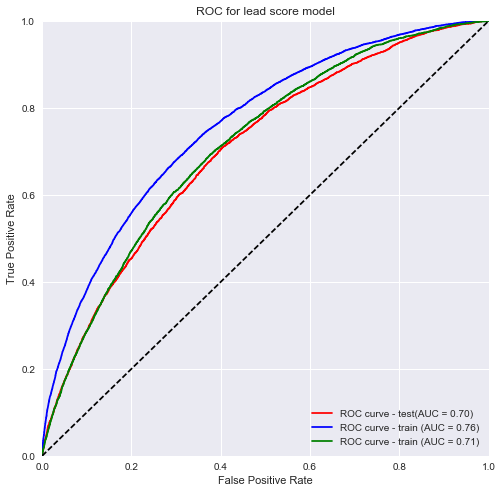

In [211]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

In [213]:
y_pred = gbm.predict(dtest)

In [214]:
print y_pred.max(), y_pred.min(), y_pred.mean()

0.709045 0.01046 0.172216


In [215]:
importance=gbm.get_fscore()

In [216]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [217]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
4,annualinc,0.039685
53,dti,0.039394
58,intrate,0.032171
67,installment,0.032171
46,mosinoldrevtlop,0.030718
3,mosinoldilacct,0.027522
64,loanamnt,0.027065
74,avgcurbal,0.026858
52,totalbclimit,0.026069
26,revolbal,0.025737


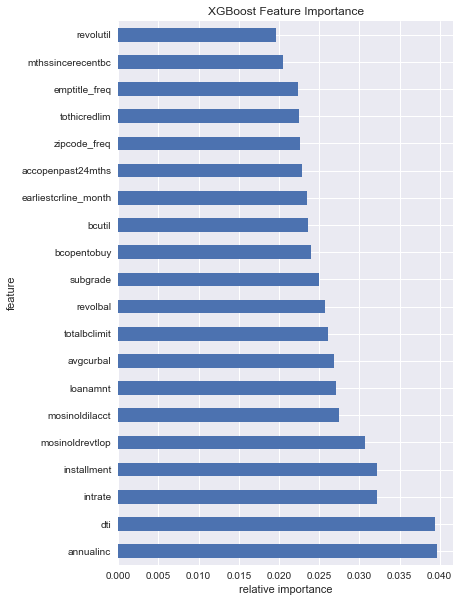

In [218]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

## Save model

In [100]:
import pickle

In [104]:
with open('model.pkl','wb') as pkl_file:
    pickle.dump(gbm, pkl_file)

In [102]:
from sklearn.externals import joblib
joblib.dump(gbm, "pima.joblib.dat")

['pima.joblib.dat']